# Chapter 6 - Linear Models and Regularization Methods


Some of the commands in this lab may take a while to run on your computer.

## Subset Selection Methods

### Best Subset Selection

Here we apply the best subset selection approach to the `Hitters` data.
We wish to predict a baseball player's `Salary` on the basis of various statistics associated with performance in the previous year.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools

import statsmodels.formula.api as smf
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
#import glmnet as gln

#from sklearn.feature_selection import SequentialFeatureSelector #!pip install -U scikit-learn, !pip install -U mlxtend
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.preprocessing import scale, StandardScaler 
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression, PLSSVD

%matplotlib inline
plt.style.use('seaborn-white')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


First of all, we note that the `Salary` variable is missing for some of the players. The `isnull()` function can be used to identify the missing observations. It returns a vector of the same length as the input vector, with a `True` value for any elements that are missing, and a `False` value for non-missing elements. The `sum()` function can then be used to count all of the missing elements.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
Hitter = pd.read_csv("/content/drive/MyDrive/NSYSU/00_Statistical_learning/Lab/Data/Hitters.csv")
Hitter.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [4]:
print(Hitter["Salary"].isnull().sum())

59


In [5]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print(Hitter.shape)

# Drop any rows the contain missing values
Hitter = Hitter.dropna()

# Print the dimensions of the modified Hitters data (263 rows x 20 columns)
print(Hitter.shape)

# One last check: should return 0
print(Hitter["Salary"].isnull().sum())

# Create dummy variables for qualitative features, since sklearn will not create dummy variables for categorical variables
qual = ['League', 'Division', 'NewLeague']
Hitter = pd.get_dummies(Hitter, columns=qual, drop_first=True)

Hitter.head()

(322, 20)
(263, 20)
0


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,1,0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,1,0,1
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,0,1,0


The `itertools.combinations` function can help us to generate all possible combinations contains exactly `k` element within from a list of elements.  We can then perform best subset selection by identifying the best model that contains a given number of predictors, where *best* is quantified using RSS. The following code implement the first stage of best subset selection.

In [6]:
list(itertools.combinations([1,2,3,4], 3))

[(1, 2, 3), (1, 2, 4), (1, 3, 4), (2, 3, 4)]

In [7]:
def get_models(k_features, X, y):
    """
    Fit all possible models that contain exactly k_features predictors.
    X is predictor and y is target or response.
    """
    
    n_features = X.shape[1]
    
    X_combos = itertools.combinations(list(X.columns), k_features)
    
    best_score = np.inf
    
    for X_label in X_combos:
        X_smf = ' + '.join(X_label)
        f     = 'Salary ~ {}'.format(X_smf)
        # Fit model
        lin_reg = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        score = lin_reg.ssr
        if score < best_score:
            best_score, best_subset = score, X_label
            best_reg = lin_reg
    

    return best_score, best_reg, best_subset

Which model with 2 predictors yields lowest RSS score?

In [8]:
X = Hitter.drop('Salary', axis=1) #19 variables remain
y = Hitter['Salary'] # put Salary as response variable

# Set number for predictors in subset
k = 2

# Get best models in subset
subset = get_models(2, X, y)

# Display results
print('This model yields the lowest RSS score for the subset of models with {} predictors:'.format(k))
print(subset)

This model yields the lowest RSS score for the subset of models with 2 predictors:
(30646559.890372835, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7faef8219510>, ('Hits', 'CRBI'))


First we fit all possible models in each subset of models with $k$ predictors. This turns out to be a very computationally expensive process as number of possible combinations without repetition is given by:

$\frac{p!}{k!(p-k)!}$

Where $p$ is number of predictors to choose from and we choose $k$ of them.

In [9]:
# get all model results
rss = []
sub = []
reg = []
kft = []

for i in range(1,5):
    best_score, best_reg, best_subset = get_models(i, X, y)
    
    rss.append(best_score)
    sub.append(best_subset)
    reg.append(best_reg)
    kft.append(i)
    print('Progess: i = {}, done'.format(i))

Progess: i = 1, done
Progess: i = 2, done
Progess: i = 3, done
Progess: i = 4, done


In [10]:
results = pd.DataFrame({'kft': kft, 'rss': rss, 'reg': reg, 'sub': sub},
                           columns = ['rss', 'reg', 'sub', 'kft']).set_index('kft')

In [11]:
results

,rss,reg,sub
kft,,,
1,3.617968e+07,<statsmodels.regression.linear_model.Regressio...,"(CRBI,)"
2,3.064656e+07,<statsmodels.regression.linear_model.Regressio...,"(Hits, CRBI)"
3,2.924930e+07,<statsmodels.regression.linear_model.Regressio...,"(Hits, CRBI, PutOuts)"
4,2.797085e+07,<statsmodels.regression.linear_model.Regressio...,"(Hits, CRBI, PutOuts, Division_W)"


We can then choose the best model using different criteria.

Text(0, 0.5, 'BIC')

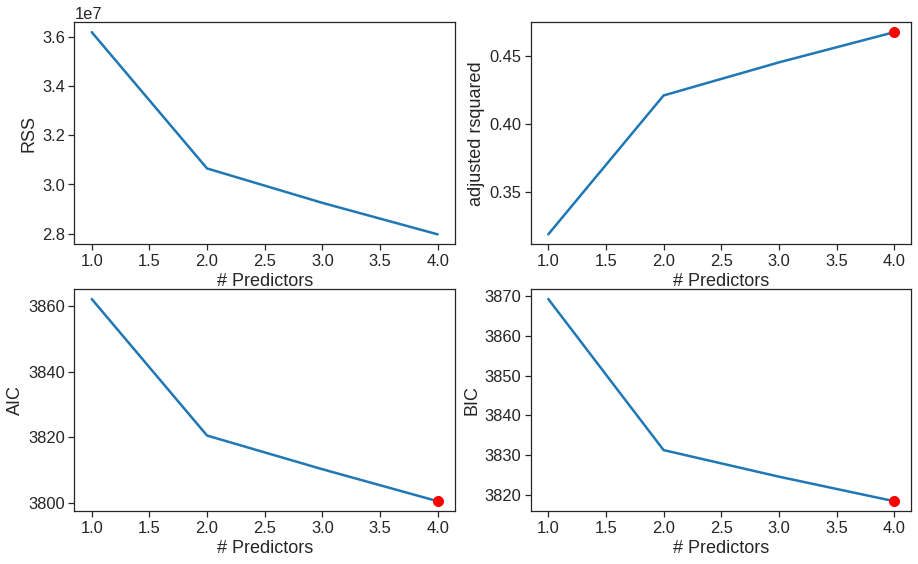

In [12]:
plt.figure(figsize=(15,9))
plt.rcParams.update({'font.size': 14, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
ax = sns.lineplot(x = "kft", y = "rss", data = results)
ax.set_xlabel('# Predictors')
ax.set_ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

results["rsquared_adj"] = results.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
ax = sns.lineplot(x = "kft", y = "rsquared_adj", data = results)
plt.plot(results["rsquared_adj"].argmax()+1, results["rsquared_adj"].max(), "or")
ax.set_xlabel('# Predictors')
ax.set_ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
results["aic"] = results.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
ax = sns.lineplot(x = "kft", y = "aic", data = results)
plt.plot(results["aic"].argmin()+1, results["aic"].min(), "or")
ax.set_xlabel('# Predictors')
ax.set_ylabel('AIC')

results["bic"] = results.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
ax = sns.lineplot(x = "kft", y = "bic", data = results)
plt.plot(results["bic"].argmin()+1, results["bic"].min(), "or")
ax.set_xlabel('# Predictors')
ax.set_ylabel('BIC')

The package [`mlxtend`](http://rasbt.github.io/mlxtend/) can help us to perform feature selection, it internally use cross-validation to estimate test errors for all possible combinations of features instead of dividing the procedure into two stage

In [13]:
# Perform an Exhaustive Search. The EFS and SFS packages use 'neg_mean_squared_error'. The 'mean_squared_error' seems to have been deprecated. I think this is just the MSE with the a negative sign.
lr = LinearRegression()
efs1 = EFS(lr, 
           min_features=1,
           max_features=4,
           scoring='neg_mean_squared_error',
           print_progress=True,
           n_jobs=-1,
           cv=5) #5-fold

In [14]:
efs1.fit(X, y)

Features: 5035/5035

ExhaustiveFeatureSelector(clone_estimator=True, cv=5,
                          estimator=LinearRegression(copy_X=True,
                                                     fit_intercept=True,
                                                     n_jobs=None,
                                                     normalize=False),
                          max_features=4, min_features=1, n_jobs=-1,
                          pre_dispatch='2*n_jobs', print_progress=True,
                          scoring='neg_mean_squared_error')

In [15]:
efs1.best_feature_names_

('AtBat', 'Hits', 'Walks', 'CRBI')

In [16]:
## This is a time consuming process, be careful. You may consider setting --ServerApp.iopub_msg_rate_limit to a larger value or not to execute this cell
r22 = []
sub = []
kft = []
for i in range(1,20):
    efs1 = EFS(lr, 
           min_features=i,
           max_features=i,
           #scoring='neg_mean_squared_error', to calculate AIC, BIC you will need rss and the estimation of sigma (also from rss) https://xavierbourretsicotte.github.io/subset_selection.html
           scoring='r2',
           print_progress=True,
           cv = 0, #no CV 
           n_jobs=-1) #parallelism
    efs1.fit(X, y)
    best_score, best_subset = efs1.best_score_, efs1.best_feature_names_
    
    r22.append(best_score)
    sub.append(best_subset)
    kft.append(i)
    print('Progess: i = {}, done'.format(i))

Features: 19/19

Progess: i = 1, done


Features: 171/171

Progess: i = 2, done


Features: 969/969

Progess: i = 3, done


Features: 3876/3876

Progess: i = 4, done


Features: 11628/11628

Progess: i = 5, done


Features: 27132/27132

Progess: i = 6, done


Features: 50388/50388

Progess: i = 7, done


Features: 75582/75582

Progess: i = 8, done


Features: 92378/92378

Progess: i = 9, done


Features: 92378/92378

Progess: i = 10, done


Features: 75582/75582

Progess: i = 11, done


Features: 50388/50388

Progess: i = 12, done


Features: 27132/27132

Progess: i = 13, done


Features: 11628/11628

Progess: i = 14, done


Features: 3876/3876

Progess: i = 15, done


Features: 969/969

Progess: i = 16, done


Features: 3/19

Progess: i = 17, done


Features: 1/1

Progess: i = 18, done
Progess: i = 19, done


In [17]:
results2 = pd.DataFrame({'kft': kft, 'r2': r22, 'sub': sub},
                           columns = ['r2', 'sub', 'kft']).set_index('kft')
results2['sub']

kft
1                                               (CRBI,)
2                                          (Hits, CRBI)
3                                 (Hits, CRBI, PutOuts)
4                     (Hits, CRBI, PutOuts, Division_W)
5              (AtBat, Hits, CRBI, PutOuts, Division_W)
6       (AtBat, Hits, Walks, CRBI, PutOuts, Division_W)
7     (Hits, Walks, CAtBat, CHits, CHmRun, PutOuts, ...
8     (AtBat, Hits, Walks, CHmRun, CRuns, CWalks, Pu...
9     (AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal...
10    (AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal...
11    (AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal...
12    (AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI...
13    (AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI...
14    (AtBat, Hits, HmRun, Runs, Walks, CAtBat, CRun...
15    (AtBat, Hits, HmRun, Runs, Walks, CAtBat, CHit...
16    (AtBat, Hits, HmRun, Runs, RBI, Walks, CAtBat,...
17    (AtBat, Hits, HmRun, Runs, RBI, Walks, CAtBat,...
18    (AtBat, Hits, HmRun, Runs, RBI, Walks,

In [18]:
def adjust_r2(r2, num_examples, num_features):
    coef = (num_examples - 1) / (num_examples - num_features - 1) 
    return 1 - (1 - r2) * coef

In [19]:
adj_r2 = []
for i, r2 in enumerate(r22):
    adj_r2.append(adjust_r2(r2=r2,
                  num_examples=X.shape[0],
                  num_features=i+1))

Text(0, 0.5, 'adjusted rsquared')

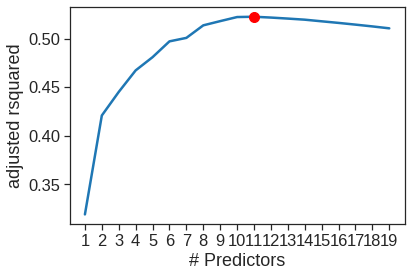

In [20]:
adj_r2 = np.array(adj_r2)
sns.lineplot(x=range(1,20), y=adj_r2)
plt.plot(adj_r2.argmax()+1, adj_r2.max(), "or")
plt.xticks(range(1,20))
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

According to the adjusted $R^2$, we see that the eleven-variable model is the best model. The predictor associated with the model is listed below.

In [21]:
results2['sub'][11]

('AtBat',
 'Hits',
 'Walks',
 'CAtBat',
 'CRuns',
 'CRBI',
 'CWalks',
 'PutOuts',
 'Assists',
 'League_N',
 'Division_W')

### Forward and Backward Stepwise Selection

In practice, the best subset is quite time-consuming,  therefore forward or backward selection is usually prefered. Note that we do not consider null model below.

In [22]:
def processSubset(X_label):
    # Fit model on feature_set and calculate RSS
    X_smf = ' + '.join(X_label)
    f     = 'Salary ~ {}'.format(X_smf)
    # Fit model
    lin_reg = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
    RSS = lin_reg.ssr
    return {'model': lin_reg, 'RSS': RSS}

In [23]:
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
      
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

def backward(predictors):
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].argmin()]

    return best_model

In [24]:
models2 = pd.DataFrame(columns=['RSS', 'model'])

predictors = [] # we start with null model M0

for i in range(1,len(X.columns)+1):
    models2.loc[i] = forward(predictors)
    exog = models2.loc[i]['model'].model.exog_names.copy()
    exog.remove('Intercept') #smf will automatically adds intercept
    predictors = exog
    print(i, predictors)

1 ['CRBI']
2 ['CRBI', 'Hits']
3 ['CRBI', 'Hits', 'PutOuts']
4 ['CRBI', 'Hits', 'PutOuts', 'Division_W']
5 ['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat']
6 ['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks']
7 ['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks']
8 ['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks', 'CRuns']
9 ['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat']
10 ['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists']
11 ['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League_N']
12 ['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League_N', 'Runs']
13 ['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League_N', 'Runs', 'Errors']
14 ['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 

We can then use `AIC` or `BIC` to choose the best model in the second stage

In [25]:
bic_f = []

for m in models2.model:
    bic_f.append(m.bic)
    
np.array(bic_f).argmin()

5

In [26]:
models3 = pd.DataFrame(columns=['RSS', 'model'], index = range(1, len(X.columns)))

predictors = X.columns # we start with full model Mp
models3.loc[len(predictors)] = processSubset(predictors)

while(len(predictors) > 1):  
    models3.loc[len(predictors)-1] = backward(predictors)
    exog = models3.loc[len(predictors)-1]['model'].model.exog_names.copy()
    exog.remove('Intercept')
    predictors = exog
    print(len(predictors), predictors)

18 ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W', 'NewLeague_N']
17 ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W', 'NewLeague_N']
16 ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W']
15 ['AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W']
14 ['AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'CAtBat', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W']
13 ['AtBat', 'Hits', 'Runs', 'Walks', 'CAtBat', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W']
12 ['AtBat', 'Hits', 'Runs', 'Walks', 'CAtBat', 'CRuns', 'CRB

In [27]:
bic_b = []

for m in models3.model:
    bic_b.append(m.bic)
    
np.array(bic_b).argmin()

7

We see that using forward stepwise selection, the best one-variable model contains only `CRBI`, and the best two-variable model additionally includes `Hits`. For this data, the best one-variable through six-variable models are each identical for best subset and forward selection. However, the best seven-variable models identified by forward stepwise selection, backward stepwise selection, and best subset selection are different.

In [28]:
print(results2['sub'][6]) #best subset
print(models2['model'][6].model.exog_names[1:]) # Do not print Intercept

('AtBat', 'Hits', 'Walks', 'CRBI', 'PutOuts', 'Division_W')
['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks']


In [29]:
print(results2['sub'][7])
print(models2['model'][7].model.exog_names[1:]) # Do not print Intercept
print(models3['model'][7].model.exog_names[1:])

('Hits', 'Walks', 'CAtBat', 'CHits', 'CHmRun', 'PutOuts', 'Division_W')
['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks']
['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts', 'Division_W']


There are also other feature selection methods available in sklearn https://scikit-learn.org/stable/modules/feature_selection.html and mlxtend http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.feature_selection/

In [ ]:
lr = LinearRegression()
sfs1 = SFS(lr, 
          k_features=19, 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=5)

sfs1.fit(X, y)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=19,
                          scoring='neg_mean_squared_error')

In [ ]:
pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(11,)","[-69552.92336716877, -213009.92207213474, -118...",-142143,"(CRBI,)",74429,57908.3,28954.1
2,"(1, 11)","[-53798.49669675372, -163254.80704040316, -104...",-124278,"(Hits, CRBI)",67031.5,52152.8,26076.4
3,"(1, 11, 17)","[-62163.90514052798, -153941.8339340546, -9746...",-120082,"(Hits, CRBI, Division_W)",59591.9,46364.6,23182.3
4,"(1, 11, 13, 17)","[-65576.39003922763, -141278.4689739879, -8255...",-117218,"(Hits, CRBI, PutOuts, Division_W)",56263.2,43774.7,21887.4
5,"(0, 1, 11, 13, 17)","[-64199.08545469467, -133171.50527159343, -836...",-114112,"(AtBat, Hits, CRBI, PutOuts, Division_W)",54818.6,42650.7,21325.4
6,"(0, 1, 5, 11, 13, 17)","[-60075.53412214349, -132306.39833204824, -765...",-110162,"(AtBat, Hits, Walks, CRBI, PutOuts, Division_W)",57689.2,44884.2,22442.1
7,"(0, 1, 3, 5, 11, 13, 17)","[-60330.25929006539, -132346.017413135, -76649...",-110553,"(AtBat, Hits, Runs, Walks, CRBI, PutOuts, Divi...",58252.1,45322.1,22661.1
8,"(0, 1, 3, 5, 6, 11, 13, 17)","[-64303.54034551581, -130892.95408839465, -745...",-110935,"(AtBat, Hits, Runs, Walks, Years, CRBI, PutOut...",57911.8,45057.3,22528.7
9,"(0, 1, 3, 5, 6, 10, 11, 13, 17)","[-63508.043800155465, -137971.21159579078, -75...",-111237,"(AtBat, Hits, Runs, Walks, Years, CRuns, CRBI,...",57344.9,44616.3,22308.1
10,"(0, 1, 3, 5, 6, 10, 11, 12, 13, 17)","[-75371.33424690236, -128223.28240695977, -742...",-110022,"(AtBat, Hits, Runs, Walks, Years, CRuns, CRBI,...",52372.5,40747.6,20373.8


### Choosing Among Models Using the Validation-Set Approach and Cross-Validation

We just saw that it is possible to choose among a set of models of different sizes using AIC, BIC, and adjusted $R^2$ in the second stage. We will now consider how to do this using the validation set and cross-validation approaches.

In order for these approaches to yield accurate estimates of the test error, we must use *only the training observations* to perform all aspects of model-fitting---including variable selection.  Therefore, the determination of which model of a given size is best must be made using *only the training observations*. This point is subtle but important. If the full data set is used to perform the best subset selection step, the validation set errors and cross-validation errors that we obtain will not be accurate estimates of the test error.

In order to use the validation set approach, we begin by splitting the observations into a training set and a test set. We also set a random seed so that the user will obtain the same training set/test set split.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [31]:
def processSubset(X_label, X_train, y_train, X_test, y_test):
    # Fit model on feature_set and calculate RSS
    X_smf = ' + '.join(X_label)
    f     = 'Salary ~ {}'.format(X_smf)
    # Fit model
    lin_reg = smf.ols(formula=f, data=pd.concat([X_train, y_train], axis=1)).fit()
    RSS = ((lin_reg.predict(X_test[list(X_label)]) - y_test) ** 2).sum() #on test set
    return {'model': lin_reg, 'RSS': RSS}

In [32]:
def forward(predictors, X_train, y_train, X_test, y_test):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train.columns if p not in predictors]
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p], X_train, y_train, X_test, y_test))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [33]:
models_test = pd.DataFrame(columns=['RSS', 'model'])

predictors = []

for i in range(1,len(X.columns)+1):
    models_test.loc[i] = forward(predictors, X_train, y_train, X_test, y_test)
    exog = models_test.loc[i]['model'].model.exog_names.copy()
    exog.remove('Intercept')
    predictors = exog
    print(i, predictors)

1 ['CRuns']
2 ['CRuns', 'Hits']
3 ['CRuns', 'Hits', 'Walks']
4 ['CRuns', 'Hits', 'Walks', 'CWalks']
5 ['CRuns', 'Hits', 'Walks', 'CWalks', 'AtBat']
6 ['CRuns', 'Hits', 'Walks', 'CWalks', 'AtBat', 'CHmRun']
7 ['CRuns', 'Hits', 'Walks', 'CWalks', 'AtBat', 'CHmRun', 'Years']
8 ['CRuns', 'Hits', 'Walks', 'CWalks', 'AtBat', 'CHmRun', 'Years', 'CAtBat']
9 ['CRuns', 'Hits', 'Walks', 'CWalks', 'AtBat', 'CHmRun', 'Years', 'CAtBat', 'Assists']
10 ['CRuns', 'Hits', 'Walks', 'CWalks', 'AtBat', 'CHmRun', 'Years', 'CAtBat', 'Assists', 'HmRun']
11 ['CRuns', 'Hits', 'Walks', 'CWalks', 'AtBat', 'CHmRun', 'Years', 'CAtBat', 'Assists', 'HmRun', 'Runs']
12 ['CRuns', 'Hits', 'Walks', 'CWalks', 'AtBat', 'CHmRun', 'Years', 'CAtBat', 'Assists', 'HmRun', 'Runs', 'League_N']
13 ['CRuns', 'Hits', 'Walks', 'CWalks', 'AtBat', 'CHmRun', 'Years', 'CAtBat', 'Assists', 'HmRun', 'Runs', 'League_N', 'NewLeague_N']
14 ['CRuns', 'Hits', 'Walks', 'CWalks', 'AtBat', 'CHmRun', 'Years', 'CAtBat', 'Assists', 'HmRun', 'Runs', '

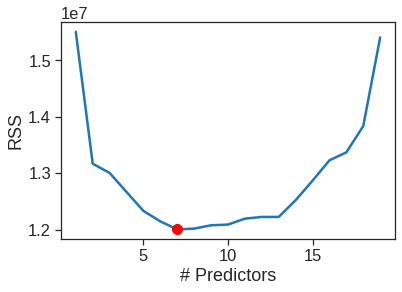

In [34]:
sns.lineplot(x=range(1,20), y=models_test['RSS'])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.plot(models_test['RSS'].argmin()+1, models_test['RSS'].min(), 'or')

Now that we know what we're looking for, let's perform forward selection on the full dataset and select the best 7-predictor model. It is important that we make use of the *full data set* in order to obtain more accurate coefficient estimates. **Note that we perform forward selection on the full data set and select the best 7-predictor model, rather than simply using the predictors that we obtained from the training set, because the best 7-predictor model on the full data set may differ from the corresponding model on the training set.**

In [35]:
models_full = pd.DataFrame(columns=['RSS', 'model'])

predictors = []
   
for i in range(1,8):
    models_full.loc[i] = forward(predictors, X, y, X, y) #use full dataset
    exog = models_full.loc[i]['model'].model.exog_names.copy()
    exog.remove('Intercept')
    predictors = exog
    print(i, predictors)

1 ['CRBI']
2 ['CRBI', 'Hits']
3 ['CRBI', 'Hits', 'PutOuts']
4 ['CRBI', 'Hits', 'PutOuts', 'Division_W']
5 ['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat']
6 ['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks']
7 ['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks']


In [36]:
print(models_test.loc[7, 'model'].model.exog_names)
print(models_full.loc[7, 'model'].model.exog_names) # we will use this one as our final model!

['Intercept', 'CRuns', 'Hits', 'Walks', 'CWalks', 'AtBat', 'CHmRun', 'Years']
['Intercept', 'CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks']


### Model selection using Cross-Validation

Now let's try to choose among the models of different sizes using cross-validation. This approach is somewhat involved, as we must perform forward selection within each of the $k$ training sets. Despite this, we see that with its clever subsetting syntax, `python` makes this job quite easy. First, we create a vector that assigns each observation to one of $k = 10$ folds, and we create a DataFrame in which we will store the results:

In [37]:
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=2)

In [38]:
# Create a DataFrame to store the results of our upcoming calculations
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1,20))
cv_errors = cv_errors.fillna(0)

In [39]:
models_cv = pd.DataFrame(columns=["RSS", "model"])

j = 0
# Outer loop iterates over all folds
for train_index, test_index in kf.split(X):
    j = j+1
    # Reset predictors
    predictors = []
    
    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = y.iloc[train_index], y.iloc[test_index]
    
    # Inner loop iterates over each size i
    for i in range(1,len(X.columns)+1):    
    
        # The perform forward selection on the full dataset minus the jth fold, test on jth fold
        models_cv.loc[i] = forward(predictors, X_train2, y_train2, X_test2, y_test2)
        
        # Save the cross-validated error for this fold
        cv_errors[j][i] = models_cv.loc[i]["RSS"]

        exog = models_cv.loc[i]['model'].model.exog_names.copy()
        exog.remove('Intercept')
        predictors = exog

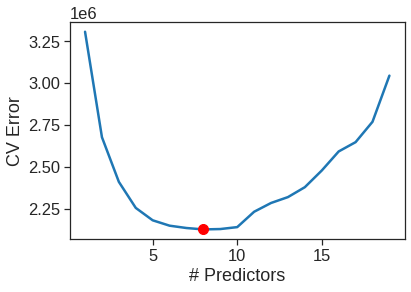

In [40]:
cv_mean = cv_errors.apply(np.mean, axis=1)

sns.lineplot(x=range(1,20), y=cv_mean)
plt.xlabel('# Predictors')
plt.ylabel('CV Error')
plt.plot(cv_mean.argmin()+1, cv_mean.min(), "or")

Cross-validation suggest 8-predictor model is the best model. We now perform best subset selection on the full data set in order to obtain the 8-variable model.

In [41]:
models_full = pd.DataFrame(columns=['RSS', 'model'])

predictors = []
   
for i in range(1,9):
    models_full.loc[i] = forward(predictors, X, y, X, y) #use full dataset
    exog = models_full.loc[i]['model'].model.exog_names.copy()
    exog.remove('Intercept')
    predictors = exog
    print(i, predictors)

1 ['CRBI']
2 ['CRBI', 'Hits']
3 ['CRBI', 'Hits', 'PutOuts']
4 ['CRBI', 'Hits', 'PutOuts', 'Division_W']
5 ['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat']
6 ['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks']
7 ['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks']
8 ['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks', 'CRuns']


There are also other supports from http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/ and https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection which implement different selection strategies.

## Ridge Regression and the Lasso

The __glmnet__ algorithms in R optimize the objective function using cyclical coordinate descent, while `scikit-learn` Ridge regression uses linear least squares with L2 regularization. They are rather different implementations, but the general principles are the same.

The __glmnet() function in R__ optimizes:
### $$ \frac{1}{N}|| X\beta-y||^2_2+\lambda\bigg(\frac{1}{2}(1−\alpha)||\beta||^2_2 \ +\ \alpha||\beta||_1\bigg) $$
(See R documentation and https://cran.r-project.org/web/packages/glmnet/vignettes/glmnet_beta.pdf)<BR>
The function supports L1 and L2 regularization. For just Ridge regression we need to use $\alpha = 0 $. This reduces the above cost function to
### $$ \frac{1}{N}|| X\beta-y||^2_2+\frac{1}{2}\lambda ||\beta||^2_2 $$

In `python`, you can also find similar functions in https://github.com/civisanalytics/python-glmnet     
    
The __sklearn Ridge()__ function on the other hand optimizes:
### $$ ||X\beta - y||^2_2 + \alpha ||\beta||^2_2 $$
which is equivalent to optimizing
### $$ \frac{1}{N}||X\beta - y||^2_2 + \frac{\alpha}{N} ||\beta||^2_2 $$


By default the `Ridge()` function performs ridge regression for an automatically selected range of $\alpha$ (or $\lambda$ in the textbook) values. However, here we have chosen to implement the function over a grid of values ranging from $\alpha=10^{10}$ to $\alpha=10^{-2}$, essentially covering the full range of scenarios from the null model containing only the intercept, to the least squares fit. The following we plot 19 coefficients (excluding intercept) for 100 different alphas

Text(0.5, 1.0, 'Ridge coefficients as a function of the regularization')

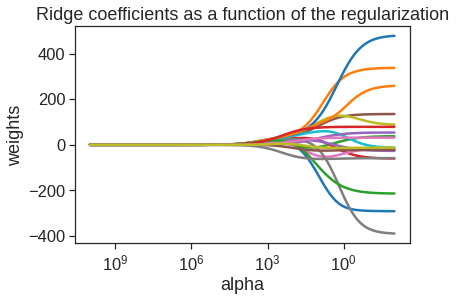

In [42]:
alphas = 10**np.linspace(10,-2,100)

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y) # We standardize features before ridge regression
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')

The above plot shows that the Ridge coefficients get larger when we decrease alpha.
We now split the samples into a training set and a test set in order to estimate the test error of ridge regression and the lasso.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

Note that if we had instead simply fit a model with just an intercept, we would have predicted each test observation using the mean of the training observations. In that case, we could compute the test set MSE like this:

In [44]:
np.mean((np.mean(y_train) - y_test)**2)

172862.23592080918

We could also get similar result by fitting a ridge regression model with a *very* large value of $\lambda$. Note that `1e10` means $10^{10}$.
This big penalty shrinks the coefficients to a very large degree and makes the model more biased, resulting in a higher MSE.

In [45]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [46]:
model = Ridge()
model.set_params(alpha=10**10)
X_scale = scaler.transform(X_train)
model.fit(X_scale, y_train)
pred = model.predict(scale(X_test))
mean_squared_error(y_test, pred)

172862.2200557664

Next we fit a ridge regression model on the training set, and evaluate its MSE on the test set

In [47]:
validation_score = []
X_scale_t = scaler.transform(X_test)
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_scale,y_train) #compare normalize=True vs standardize
    validation_score.append(mean_squared_error(model.predict(X_scale_t),y_test))

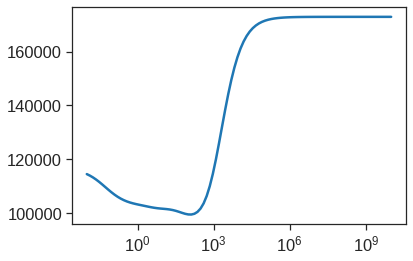

In [48]:
sns.lineplot(x=alphas,y=validation_score)
plt.xscale('log')

In [49]:
np.argmin(validation_score)

65

Therefore, we see that the value of alpha that results in the smallest cross-validation error is the 64th. What is the test MSE associated with this value of alpha?

In [50]:
alphas[65], validation_score[65]

(132.19411484660287, 99557.32756698191)

We can also do built-in cross-validation using `RidgeCV`

In [51]:
kf = KFold(n_splits=10, shuffle=True, random_state=2)
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=kf)
ridgecv.fit(X_scale, y_train)

RidgeCV(alphas=array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.57933225e+07, 4.97702356e+07,
       3.76493581e+07, 2.84803587e+0...
       6.57933225e-01, 4.97702356e-01, 3.76493581e-01, 2.84803587e-01,
       2.15443469e-01, 1.62975083e-01, 1.23284674e-01, 9.32603347e-02,
       7.05480231e-02, 5.33669923e-02, 4.03701726e-02, 3.05385551e-02,
       2.31012970e-02, 1.74752840e-02, 1.32194115e-02, 1.00000000e-02]),
        cv=KFold(n_splits=10, random_state=2, shuffle=True), fit_intercept=True,
        gcv_mode=None, normalize=False, scoring='neg_mean_squared_error',
        store_cv_values=False)

In [52]:
ridgecv.alpha_

100.0

In [53]:
model.set_params(alpha=ridgecv.alpha_)
model.fit(X_scale, y_train)
mean_squared_error(y_test, model.predict(X_scale_t))

99586.56834382795

#### Fit model to full data set

In [54]:
model.fit(scale(X), y)

Ridge(alpha=100.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [55]:
pd.Series(model.coef_.flatten(), index=X.columns)

AtBat          -0.006619
Hits           49.467498
HmRun          -0.859718
Runs           28.891970
RBI            22.425519
Walks          41.183554
Years          -2.737654
CAtBat         24.915049
CHits          44.636902
CHmRun         38.851734
CRuns          45.225776
CRBI           47.320463
CWalks          3.558932
PutOuts        56.671318
Assists         7.335151
Errors        -13.493719
League_N       14.878188
Division_W    -48.564908
NewLeague_N     2.817544
dtype: float64

As expected, none of the coefficients are zero---ridge regression does not perform variable selection!

You can also fit the ridge regression with LOOCV, this should be efficient since their is corresponding shortcut equation

In [56]:
ridgeloocv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', gcv_mode='auto')
ridgeloocv.fit(X_scale, y_train)

RidgeCV(alphas=array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.57933225e+07, 4.97702356e+07,
       3.76493581e+07, 2.84803587e+0...
       6.57933225e-01, 4.97702356e-01, 3.76493581e-01, 2.84803587e-01,
       2.15443469e-01, 1.62975083e-01, 1.23284674e-01, 9.32603347e-02,
       7.05480231e-02, 5.33669923e-02, 4.03701726e-02, 3.05385551e-02,
       2.31012970e-02, 1.74752840e-02, 1.32194115e-02, 1.00000000e-02]),
        cv=None, fit_intercept=True, gcv_mode='auto', normalize=False,
        scoring='neg_mean_squared_error', store_cv_values=False)

In [57]:
ridgeloocv.alpha_

75.64633275546291

In [58]:
model.set_params(alpha=ridgeloocv.alpha_)
model.fit(X_scale, y_train)
mean_squared_error(y_test, model.predict(X_scale_t))

99820.74305168974

In [59]:
model.fit(scale(X), y)

Ridge(alpha=75.64633275546291, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

### The Lasso

We saw that ridge regression with a wise choice of alpha may outperform least squares as well as the null model on the `Hitters` data set. We now ask whether the lasso can yield either a more accurate or a more interpretable model than ridge regression. The following we plot 19 coefficients (excluding intercept) for 100 different alphas.

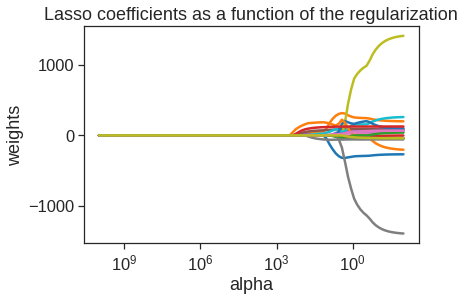

In [60]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

We can see from the coefficient plot that depending on the choice of tuning parameter, some of the coefficients will be exactly equal to zero. We now perform cross-validation and compute the associated test error.

In [61]:
kf = KFold(n_splits=10, shuffle=True, random_state=2)
lassocv = LassoCV(alphas=None, cv=kf, max_iter=10000)
lassocv.fit(X_scale, y_train.values.ravel())

LassoCV(alphas=None, copy_X=True,
        cv=KFold(n_splits=10, random_state=2, shuffle=True), eps=0.001,
        fit_intercept=True, max_iter=10000, n_alphas=100, n_jobs=None,
        normalize=False, positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [62]:
lassocv.alpha_

25.649654020305032

In [63]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_scale, y_train)
mean_squared_error(y_test, lasso.predict(X_scale_t))

104853.47279766493

In [64]:
# fit the full model
lasso.fit(scale(X), y)

Lasso(alpha=25.649654020305032, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [65]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat            0.000000
Hits            80.723891
HmRun            0.000000
Runs             0.000000
RBI              0.000000
Walks           45.833055
Years            0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun           0.000000
CRuns           65.022016
CRBI           129.889483
CWalks           0.000000
PutOuts         55.241441
Assists         -0.000000
Errors          -0.000000
League_N         0.000000
Division_W     -43.731588
NewLeague_N      0.000000
dtype: float64

The test set MSE is very similar to the test MSE of ridge regression with $\alpha$ chosen by cross-validation.

However, the lasso has a substantial advantage over ridge regression in that the resulting coefficient estimates are sparse. Here we see that 13 of the 19 coefficient estimates are exactly zero. So the lasso model with $\alpha$ chosen by cross-validation contains only six variables.

## PCR and PLS Regression

### Principal Components Regression

Principal components regression (PCR) can be performed using the `pca` function. We now apply PCR to the `Hitters` data, in order to predict `Salary`. Again, we ensure that the missing values have been removed from the data, as described in Section 6.5.1.

In [66]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X)) #standardize before PCA

print(pca.components_.shape)
pd.DataFrame(pca.components_.T).loc[:4,:5]

(19, 19)


,0,1,2,3,4,5
0,0.198290,-0.383784,0.088626,0.031967,0.028117,-0.070646
1,0.195861,-0.377271,0.074032,0.017982,-0.004652,-0.082240
2,0.204369,-0.237136,-0.216186,-0.235831,0.077660,-0.149646
3,0.198337,-0.377721,-0.017166,-0.049942,-0.038536,-0.136660
4,0.235174,-0.314531,-0.073085,-0.138985,0.024299,-0.111675


In [67]:
print(X_reduced.shape)
pd.DataFrame(X_reduced).loc[:4,:5]

(263, 19)


,0,1,2,3,4,5
0,-0.009649,1.870522,1.265145,-0.935481,1.109636,1.211972
1,0.411434,-2.429422,-0.909193,-0.264212,1.232031,1.826617
2,3.466822,0.825947,0.555469,-1.616726,-0.857488,-1.028712
3,-2.558317,-0.230984,0.519642,-2.176251,-0.820301,1.491696
4,1.027702,-1.573537,1.331382,3.494004,0.983427,0.513675


In [68]:
# Variance explained by the principal components
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([38.31, 60.15, 70.84, 79.03, 84.29, 88.63, 92.26, 94.96, 96.28,
       97.25, 97.97, 98.64, 99.14, 99.46, 99.73, 99.88, 99.95, 99.98,
       99.99])

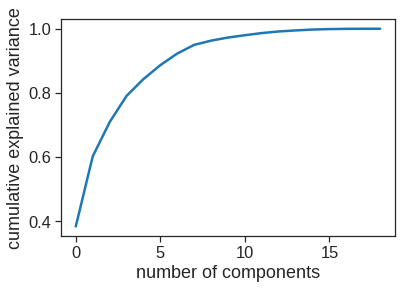

In [69]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)) #scree plot
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

#### Fitting PCA with training data

In this method, we use the train/val/test split scheme like the lab in the textbook

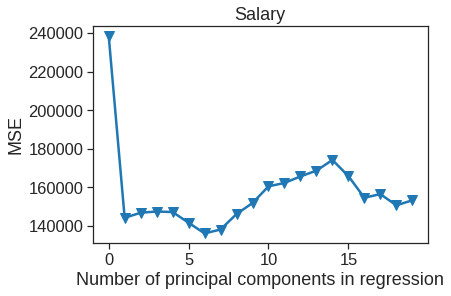

In [70]:
pca2 = PCA()
X_reduced_train = pca2.fit_transform(X_scale)
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=True, random_state=2)

mse = []
regr = LinearRegression()
# Calculate MSE with only the intercept (no principal components in regression) 
score = -1*cross_val_score(regr, np.ones((n,1)), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced_train[:,:i], y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.arange(0, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

In [71]:
np.array(mse).argmin() #note mse contains no pc

6

#### Transform test data with PCA loadings and fit regression on 6 principal components

In [72]:
X_reduced_test = pca2.transform(X_scale_t)[:,:7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:7], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

108266.9590347202

In [73]:
# Fit regression model on the whole data 
regr = LinearRegression()
regr.fit(X_reduced[:,:7], y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Partial Least Squares

Scikit-learn `PLSRegression` gives same results as the pls package in R when using 'method='oscorespls'.  
See documentation:
http://scikit-learn.org/dev/modules/generated/sklearn.cross_decomposition.PLSRegression.html#sklearn.cross_decomposition.PLSRegression

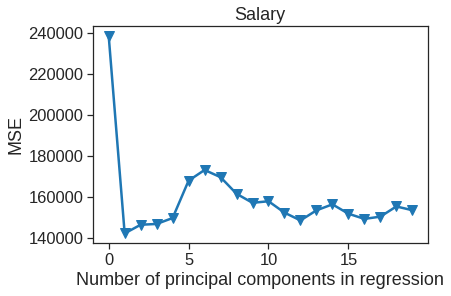

In [75]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=True, random_state=2)

mse = []

score = -1*cross_val_score(regr, np.ones((n,1)), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = -1*cross_val_score(pls, X_scale, y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.arange(0, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

In [76]:
np.array(mse).argmin()

1

The lowest cross-validation error occurs when only $M=1$ partial least squares directions are used. We now evaluate the corresponding test set MSE.

In [77]:
pls = PLSRegression(n_components=1)
pls.fit(X_scale, y_train)

mean_squared_error(y_test, pls.predict(X_scale_t))

101462.13107757184

In [78]:
pls = PLSRegression(n_components=1)
pls.fit(scale(X), y)

PLSRegression(copy=True, max_iter=500, n_components=1, scale=True, tol=1e-06)